# 1. Data Loading and Filtering Records with Focus (Primary or Secondary)

In [1]:
import json
with open("Data/meta_test.json", "r", encoding="utf-8") as f:
    records = json.load(f)
# Filter JSON entries where focus is primary or secondary
filtered_records = [entry for entry in records if any(f in ["primary", "secondary"] for f in entry["metadata"].get("focus", []))]

# Calculation of Primary and Secondary records %
filtered_records_percent = round(((len(filtered_records)/len(records)) * 100), 2)

print(f"Only {filtered_records_percent}% of entire records are Primary or Secondary ")



Only 85.42% of entire records are Primary or Secondary 


# 2. Data Restructuring

In [2]:
def metadata_restructuring(records):
    restructured_records = []
    for record in records:
        metadata = record.get("metadata", {}).copy()  # copy to avoid mutating original

        # Explicitly ensure top-level fields are part of metadata
        for field in ["root_name", "search_term", "synonyms", "PMID", "pubmed_type"]:
            if field in record:
                metadata[field] = record[field]

        restructured_records.append({"metadata": metadata})
    return restructured_records

restructured_records = metadata_restructuring(filtered_records)

### Optional: Validation Checkpoint to get matching record from json_list

In [3]:
# def get_record_by_pmid(json_list, pmid):
#     """Pass PMID and get matching record from json_list"""
#     for record in json_list:
#         if record['metadata']['PMID'] == pmid:
#             return record
#     return None


# # Example usage:
# result = get_record_by_pmid(restructured_records, 11524119)

# if result:
#     print(json.dumps(result, indent=2))  # Prints the entire matching record
# else:
#     print("PMID not found")

# 3. Flattening the Data

In [4]:
for record in restructured_records:
    metadata = record["metadata"]

    # Process interventions with Parallel - Indexing
    interventions = metadata.get("interventions", [])
    record["intervention_names"] = [i.get("ingredient") for i in interventions]
    record["intervention_dosages"] = [i.get("daily_dosage") for i in interventions]
    record["intervention_units"] = [i.get("units") if i.get("units") else "" for i in interventions]
    record["intervention_original_texts"] = [i.get("original_text") for i in interventions]

    # Process outcomes with Parallel - Indexing
    outcomes = metadata.get("outcomes", [])
    record["biomarker_names"] = [o["name"] for o in outcomes if o["domain"] == "biomarker"]
    record["biomarker_types"] = [o["type"] for o in outcomes if o["domain"] == "biomarker"]
    record["biomarker_results"] = [o["result"] for o in outcomes if o["domain"] == "biomarker"]

    record["function_names"] = [o["name"] for o in outcomes if o["domain"] == "function"]
    record["function_types"] = [o["type"] for o in outcomes if o["domain"] == "function"]
    record["function_results"] = [o["result"] for o in outcomes if o["domain"] == "function"]

    record["condition_names"] = [o["name"] for o in outcomes if o["domain"] == "condition"]
    record["condition_types"] = [o["type"] for o in outcomes if o["domain"] == "condition"]
    record["condition_results"] = [o["result"] for o in outcomes if o["domain"] == "condition"]


    # Delete original detailed fields
    for key in ["interventions", "outcomes", "biomarkers", "functions", "conditions"]:
        metadata.pop(key, None)


In [5]:
with open("flatten.json", "w", encoding="utf-8") as f:
    json.dump(restructured_records, f, indent=2, ensure_ascii=False)

# 4. Data Ingestion into PineCone

### 4a. Converting into Embeddings and performing Sematic Chunking

In [6]:
import pandas as pd
from llama_index.core import Document, VectorStoreIndex, StorageContext
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from UPDATED_meta_data_generation import *
from dotenv import load_dotenv
import os
from tqdm import tqdm

load_dotenv()

# --------------------------
# Initialize Pinecone
# --------------------------
INDEX_NAME = "pubmed-abstracts-p4"
client = Pinecone(api_key=os.getenv("PINECONE_API"))
spec = ServerlessSpec(cloud="aws", region="us-east-1")

if INDEX_NAME not in client.list_indexes().names():
    client.create_index(
        name=INDEX_NAME,
        dimension=768,
        metric="cosine",
        spec=spec
    )

pinecone_index = client.Index(INDEX_NAME)
vector_store = PineconeVectorStore(pinecone_index=pinecone_index)

# --------------------------
# Initialize embedding + semantic chunker
# --------------------------
embed_model = HuggingFaceEmbedding(model_name="NeuML/pubmedbert-base-embeddings")

splitter = SemanticSplitterNodeParser(
    buffer_size=1,
    breakpoint_percentile_threshold=95,
    embed_model=embed_model
)


# --------------------------
# Build all semantic nodes
# --------------------------
all_nodes = []

for idx, row in enumerate(tqdm(restructured_records, desc="Processing papers")):
    md = row["metadata"]
    paper = fetch_extract_and_abstract(md['PMID'])
    title = paper['title']
    abstract = paper['abstract']

    # Title node
    title_node = Document(
        text=title,
        metadata={"type": "title", "node_index": 0, **md}
    )
    all_nodes.append(title_node)

    # Abstract nodes
    abstract_doc = Document(
        text=abstract,
        metadata={"type": "abstract", **md}
    )

    abstract_nodes = splitter.get_nodes_from_documents([abstract_doc])
    for i, node in enumerate(abstract_nodes, start=1):
        node.metadata["node_index"] = i
        all_nodes.append(node)

# --------------------------
# Save nodes both to Pinecone (for vector) and local docstore
# --------------------------
# print("Indexing nodes into Pinecone and persisting locally...")

# index = VectorStoreIndex(
#     all_nodes,
#     storage_context=storage_context,
#     embed_model=embed_model,
#     show_progress=True
# )

# Persist docstore + metadata to disk

# --------------------------
# Create a persistent docstore
# --------------------------
docstore = SimpleDocumentStore()

docstore.add_documents(all_nodes)

storage_context = StorageContext.from_defaults(
    vector_store=vector_store,
    docstore=docstore
)

storage_context.persist(persist_dir="pubmed_nodes")



/usr/local/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
Processing papers: 100%|██████████| 82/82 [00:47<00:00,  1.72it/s]


### 4b. Injecting Embedded Chunks into PineCone

In [7]:
# --------------------------
# 4️ Store nodes in Pinecone on Cloud via LlamaIndex
# --------------------------
index = VectorStoreIndex([], storage_context=storage_context, embed_model=embed_model)
if all_nodes:
    index.insert_nodes(all_nodes, show_progress=True)
else:
    print("WARNING: No nodes to upsert.")

Generating embeddings:   0%|          | 0/247 [00:00<?, ?it/s]

Upserted vectors:   0%|          | 0/247 [00:00<?, ?it/s]

In [8]:
# Get Stats of Vector Index
stats = pinecone_index.describe_index_stats()
stats

{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

# Debugging: Similarity Search

In [9]:
# Create a retriever for similarity search
retriever = index.as_retriever(similarity_top_k=10)  # retrieve top 10 similar chunks
query_text = " Cedrus, Hesperopeuce, Keteleeria, Pseudolarix, and Tsuga and preliminary inferences on the taxonomy of Pinaceae."

results = retriever.retrieve(query_text)
for res in results:
    print("Score:", res.score)
    print("Text:", res.node.text)
    print("PMID:", res.node.metadata.get("PMID"))
    print("Type:", res.node.metadata.get("type"))
    print("-" * 80)


# Debugging: Reconstruction the Paper

In [10]:
# Function to reconstruct a paper from nodes
def reconstruct_paper(all_nodes, pmid):
    # Filter nodes belonging to this paper
    paper_nodes = [node for node in all_nodes if str(node.metadata.get("PMID")) == str(pmid)]

    # Sort nodes by node_index
    paper_nodes = sorted(paper_nodes, key=lambda x: x.metadata.get("node_index", 0))
    print("Noumber of Nodes:",len(paper_nodes))
    # Concatenate the text
    full_text = "\n".join([node.text for node in paper_nodes])

    return full_text

# Example usage
pmid_to_reconstruct = restructured_records[2]['metadata']['PMID']
full_paper_text = reconstruct_paper(all_nodes, pmid_to_reconstruct)

print("Reconstructed Paper Text:")
print(full_paper_text)


Noumber of Nodes: 3
Reconstructed Paper Text:
New woody and ambery notes from cedarwood and turpentine oil.
The development of a new product in the chemical industry is still driven by needs like technical properties, price/performance ratio, biodegradability, or product safety. However, in terms of improving more and more on ecological criteria, summarized under such catchphrases as sustainable development or green chemistry, another important aspect is to use renewable resources as starting materials. This is not significantly new in fragrance chemistry, and there are a lot of raw materials in the perfume oils that are derived from molecules of renewable resources. 
Two commonly used materials are: longifolene (from turpentine oil) and cedrene (from cedarwood oil). These compounds are very suitable for the synthesis of woody and ambery notes, and even though it seemed that all possibilities were exhausted, it is actually still feasible to discover new molecules with excellent olfacto

### Optional: Delete PineCone Index

In [11]:
# from pinecone import Pinecone
# import os
# from dotenv import load_dotenv
# load_dotenv()

# INDEX_NAME = "pubmed-abstracts"

# # Initialize Pinecone client
# client = Pinecone(api_key=os.getenv("PINECONE_API"))

# try:
#     client.delete_index(name=INDEX_NAME)
#     print("Index deleted")
# except:
#     print("Data base is empty")

### Opitional: Check available Indices

In [12]:
# indexes = client.list_indexes()
# print(f"Available indexes: {indexes.names()}")
# print(f"Current index name: {INDEX_NAME}")

# Hybrid Search Retrival Pipeline directly from Pinecone
Note: Make Sure to restart the kernal before you run the below cell to ensure that data is not being retrived from local- memory/in-memory/RAM

In [13]:
from llama_index.core import StorageContext
#from llama_index.core.storage.docstore import SimpleDocumentStore

# Just point to the folder where you persisted
storage_context = StorageContext.from_defaults(persist_dir="pubmed_nodes")

# Now access your persisted documents
docstore = storage_context.docstore
print("Number of documents:", len(docstore.docs))


Number of documents: 247


In [ ]:
from pinecone import Pinecone
from llama_index.vector_stores.pinecone import PineconeVectorStore
from llama_index.core import StorageContext, VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import QueryFusionRetriever
from llama_index.core.llms import MockLLM
from dotenv import load_dotenv
import os

load_dotenv()

pc = Pinecone(api_key=os.getenv("PINECONE_API"))
pinecone_index = pc.Index(INDEX_NAME)

vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
docstore = SimpleDocumentStore.from_persist_path("pubmed_nodes/docstore.json")
storage_context = StorageContext.from_defaults(vector_store=vector_store, docstore=docstore)

embed_model = HuggingFaceEmbedding(model_name="NeuML/pubmedbert-base-embeddings")

index = VectorStoreIndex.from_vector_store(
    vector_store=vector_store,
    storage_context=storage_context,
    embed_model=embed_model
)

# Create vector retriever
vector_retriever = index.as_retriever(similarity_top_k=10)

# Create BM25 retriever for keyword-based search
# Ensure you have the documents loaded in memory for BM25
all_nodes = list(docstore.docs.values())
bm25_retriever = BM25Retriever.from_defaults(
    nodes=all_nodes,
    similarity_top_k=5
)

# bm25_retriever = BM25Retriever.from_defaults(
#     docstore=docstore,
#     similarity_top_k=5
# )

# Create hybrid retriever using QueryFusionRetriever
# This combines results from both retrievers
hybrid_retriever = QueryFusionRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    retriever_weights=[0.8, 0.2],  # Equal weight to both retrievers
    llm=MockLLM(),  # Use MockLLM to avoid needing OpenAI API key
    use_async=False,
    #mode="relative_score",
    mode="reciprocal_rerank",
)

# Perform hybrid search
query = "Against Streptococcus mutans in vitro, how did cedarwood oil perform relative to cinnamon and lemongrass oils, and which assay was used to measure activity?"
results = hybrid_retriever.retrieve(query)

# # Display results
for res in results:
    print("Score:", res.score)
    print("Text:", res.node.text)
    print("PMID:", res.node.metadata.get("PMID"))
    print("Type:", res.node.metadata.get("type"))
    print("-" * 80)


Score: 0.03333333333333333
Text: Agar well diffusion assay was used to measure antibacterial activity. Zone of inhibition was measured around the filter paper in millimeters with vernier caliper. Cinnamon oil showed highest activity against Streptococcus mutans followed by lemongrass oil and cedarwood oil. Wintergreen oil, lime oil, peppermint oil and spearmint oil showed no antibacterial activity. Cinnamon oil, lemongrass oil, cedarwood oil, clove oil and eucalyptus oil exhibit antibacterial property against S. mutans. The use of these essential oils against S. mutans can be a viable alternative to other antibacterial agents as these are an effective module used in the control of both bacteria and yeasts responsible for oral infections.
PMID: 22430697
Type: abstract
--------------------------------------------------------------------------------
Score: 0.03278688524590164
Text: Many essential oils have been advocated for use in complementary medicine for bacterial and fungal infection

In [15]:
keyword_result = bm25_retriever.retrieve(query)
# Display results
for res in keyword_result:
    print("Score:", res.score)
    print("Text:", res.node.text)
    print("PMID:", res.node.metadata.get("PMID"))
    print("Type:", res.node.metadata.get("type"))
    print("-" * 80)

Score: 19.333717346191406
Text: Agar well diffusion assay was used to measure antibacterial activity. Zone of inhibition was measured around the filter paper in millimeters with vernier caliper. Cinnamon oil showed highest activity against Streptococcus mutans followed by lemongrass oil and cedarwood oil. Wintergreen oil, lime oil, peppermint oil and spearmint oil showed no antibacterial activity. Cinnamon oil, lemongrass oil, cedarwood oil, clove oil and eucalyptus oil exhibit antibacterial property against S. mutans. The use of these essential oils against S. mutans can be a viable alternative to other antibacterial agents as these are an effective module used in the control of both bacteria and yeasts responsible for oral infections.
PMID: 22430697
Type: abstract
--------------------------------------------------------------------------------
Score: 16.689756393432617
Text: Many essential oils have been advocated for use in complementary medicine for bacterial and fungal infections.

In [16]:
vector_result = vector_retriever.retrieve(query)
# Display results
for res in vector_result:
    print("Score:", res.score)
    print("Text:", res.node.text)
    print("PMID:", res.node.metadata.get("PMID"))
    print("Type:", res.node.metadata.get("type"))
    print("-" * 80)

# Evaluation

In [17]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
    RetrieverEvaluator
)
from llama_index.core.schema import MetadataMode, TextNode
import uuid
from typing import List, Any
import random
from llama_index.llms.openai import OpenAI
import asyncio
import matplotlib.pyplot as plt
import pandas as pd


In [18]:
pubmed_literature_search_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the above biomedical context (and not external knowledge), \
generate {num_questions_per_chunk} PubMed literature-style search queries.

Task:
Your task is to write realistic PubMed or biomedical database search queries \
that a researcher or clinician might use to retrieve this abstract. \
Restrict the queries strictly to the information provided.

Explanation of Literature-style search queries:
Concise keyword-based or natural-language queries similar to what researchers enter into PubMed or Google Scholar.

Example queries:
1. "role of IL-6 in inflammatory bowel disease"
2. "oxidative stress biomarkers in Alzheimer’s progression"
3. "COVID-19 vaccine efficacy in immunocompromised adults"
"""

pubmed_concept_seeking_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} concept-seeking biomedical questions.

Task:
Your task is to create abstract or high-level conceptual questions \
that require multi-sentence explanations, reasoning, or interpretation \
based only on the provided biomedical abstract.

Explanation of Concept-seeking questions:
These are open-ended research-style questions that probe mechanisms, hypotheses, or conceptual relationships.

Example queries:
1. "How does mitochondrial dysfunction contribute to neurodegenerative diseases?"
2. "Why is the gut microbiome considered a key regulator of immune homeostasis?"
3. "What mechanisms link chronic inflammation to cancer initiation?"
"""


pubmed_fact_seeking_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} fact-seeking biomedical questions.

Task:
Your task is to write precise fact-based questions \
that can be directly answered from the information in the abstract. \
Restrict the questions to the factual content provided.

Explanation of Fact-seeking questions:
Specific questions with clear, verifiable answers from the text.

Example queries:
1. "What concentration of drug X inhibited tumor growth in mice?"
2. "Which cytokines were upregulated following infection?"
3. "How many participants were included in the clinical trial?"
"""

pubmed_keyword_queries_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} keyword-style biomedical queries.

Task:
Your task is to write compact keyword-based queries \
that capture the key biomedical terms, entities, or relationships \
from the given abstract. Restrict the output to only the key terms.

Explanation of Keyword queries:
Short, information-dense phrases focusing on diseases, genes, pathways, or treatments.

Example queries:
1. "apoptosis p53 regulation"
2. "insulin resistance type 2 diabetes"
3. "CRISPR Cas9 gene editing therapy"
"""

pubmed_queries_with_misspellings_tmpl = """\
Context information from a PubMed abstract is provided below.

---------------------
{context_str}
---------------------

Given the context information (and not prior knowledge), \
generate {num_questions_per_chunk} biomedical queries with misspellings.

Task:
Your task is to create search-like queries that intentionally include \
common spelling mistakes, transpositions, missing characters, \
and typical human typing errors while still resembling biomedical queries. \
Restrict the misspelled words to terms that appear or are derived from the context.

Explanation of Queries with Misspellings:
These mimic noisy user input where biomedical terms may be misspelled or mistyped.

Example queries:
1. "mitochodrial dysfuncton in Alzhimers"
2. "inflamation markrs in arthrits"
3. "oxdatve stres biomarkrs in cancer"
"""



In [19]:
def create_word_based_search_queries(text, num_questions_per_chunk, min_words=5, max_words=15):
    """
    Create search queries by randomly selecting a substring of complete words.

    :param text: Text string.
    :param min_words: Minimum number of words in the substring.
    :param max_words: Maximum number of words in the substring.
    :return: List of search queries.
    """
    words = text.split()
    queries = []

    if len(words) < min_words:
        return [text]

    for _ in range(num_questions_per_chunk):  # Generate multiple queries per text
        start_index = random.randint(0, len(words) - min_words)
        end_index = random.randint(start_index + min_words, min(start_index + max_words, len(words)))
        substring = ' '.join(words[start_index:end_index])
        queries.append(substring)

    return queries

def generate_query_context_pairs(
    nodes: List[TextNode],
    num_questions_per_chunk: int = 2,
    min_words=5,
    max_words=15
) -> EmbeddingQAFinetuneDataset:
    """Generate examples given a set of nodes."""
    node_dict = {
        node.node_id: node.get_content(metadata_mode=MetadataMode.NONE)
        for node in nodes
    }

    queries = {}
    relevant_docs = {}
    for node_id, text in node_dict.items():
        generated_queries = create_word_based_search_queries(text,
                                                             num_questions_per_chunk,
                                                             min_words,
                                                             max_words)

        for query in generated_queries:
            question_id = str(uuid.uuid4())
            queries[question_id] = query
            relevant_docs[question_id] = [node_id]

    # construct dataset
    return EmbeddingQAFinetuneDataset(
        queries=queries, corpus=node_dict, relevant_docs=relevant_docs
    )

In [20]:
from dotenv import load_dotenv
import os
load_dotenv()
# Deing LLM for query generation
llm = OpenAI(model='gpt-4o', temperature=0.1,api_key=os.getenv("OPEN_AI_API"))

In [21]:
from llama_index.core.storage.docstore import SimpleDocumentStore

# Load the document store from the persisted JSON
docstore = SimpleDocumentStore.from_persist_path("pubmed_nodes/docstore.json")

# Extract all nodes (TextNode objects)
all_nodes = list(docstore.docs.values())[:60]

print(f"✅ Loaded {len(all_nodes)} nodes from docstore.json")


✅ Loaded 60 nodes from docstore.json


In [22]:
# Literature search queries
literature_search_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_literature_search_queries_tmpl
)

# Concept seeking queries
concept_seeking_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_concept_seeking_queries_tmpl
)

# Fact seeking queries
fact_seeking_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_fact_seeking_queries_tmpl
)

# Keyword queries
keyword_queries_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_keyword_queries_tmpl
)

# Queries with misspellings
queries_with_misspellings_multi_document = generate_question_context_pairs(
    all_nodes, llm=llm, num_questions_per_chunk=1, qa_generate_prompt_tmpl = pubmed_queries_with_misspellings_tmpl
)

# Exact string match queries
exact_string_search_queries_multi_document = generate_query_context_pairs(all_nodes, num_questions_per_chunk=1)

100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


## Examine synthetically created queries from multiple documents.

In [23]:
start_idx = 0
end_idx = 5

In [24]:
# Literature search queries
queries = list(literature_search_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['"inhalation aromatherapy during radiotherapy placebo-controlled double-blind randomized trial"',
 '"aromatherapy inhalation effects on anxiety during radiotherapy"',
 '"effectiveness of aromatherapy on anxiety and depression using HADS and SPHERE scores"',
 '"pressurized fluid extraction of cedarwood oil from Juniperus virginiana"',
 '"comparison of liquid CO2 and supercritical fluid extraction for cedarwood oil yield and composition"']

In [25]:
# concept seeking queries
queries = list(concept_seeking_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['What potential mechanisms could explain the effects of inhalation aromatherapy on patient outcomes during radiotherapy, and how might these mechanisms differ from those of a placebo effect?',
 'How might the inhalation of different types of aromatherapy oils influence the psychological and physiological responses of patients undergoing radiotherapy, and what underlying mechanisms could explain these effects?',
 'How might the presence of fragrance in aromatherapy influence anxiety outcomes differently compared to the use of carrier oil alone, and what underlying mechanisms could explain these differences?',
 'What are the potential advantages and mechanisms of using pressurized fluids for the extraction of essential oils, such as cedarwood oil, from plant sources like Juniperus virginiana compared to traditional extraction methods?',
 'How do the differences in extraction conditions, such as temperature and pressure, influence the chemical composition and efficacy of cedarwood oil ex

In [26]:
# fact seeking queries
queries = list(fact_seeking_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['What type of study design was used in the research on inhalation aromatherapy during radiotherapy?',
 'How many patients were randomly assigned to receive aromatherapy during radiotherapy in the study?',
 'What was the outcome of HADS anxiety scores in the carrier oil only group compared to the fragrant arms at treatment completion?',
 'What method is used for the extraction of cedarwood oil from Juniperus virginianna?',
 'What was the range of cumulative yields of cedarwood oil (CWO) from cedarwood chips using 80 L of carbon dioxide?']

In [27]:
# keyword queries
queries = list(keyword_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['"inhalation aromatherapy radiotherapy trial"',
 '"aromatherapy anxiety radiotherapy HADS SPHERE"',
 '"aromatherapy anxiety HADS SPHERE scores"',
 '"pressurized fluid extraction cedarwood oil"',
 '"cedarwood oil extraction liquid CO2 supercritical fluid"']

In [28]:
# queries with misspellings
queries = list(queries_with_misspellings_multi_document.queries.values())
queries[start_idx:end_idx]


['"inhaltion aromatherpy during radiothrapy trial"',
 '"aromatherpy efects on anxity during radiothrapy"',
 '"aromatherpy efectivness on anxity and depresion scores"',
 '"pressurzed fluid extrction of cedarwod oil from Juniprus virginiana"',
 '"cedarwod oil extrction using liquid carbondioxide"']

In [29]:

# exact string search queries
queries = list(exact_string_search_queries_multi_document.queries.values())
queries[start_idx:end_idx]

['a placebo-controlled double-blind randomized trial.',
 'randomly assigned to receive either',
 'carrier oil only group compared with either of',
 'of cedarwood oil from Juniperus',
 'CO(2) conditions (i.e., 25 degrees C), the extraction']

## Format multiple document queries

In [30]:
# Create dataset dictionaries for multiple document queries
datasets_multi_document = {
    "literature_search_queries": literature_search_queries_multi_document,
    "concept_seeking_queries": concept_seeking_queries_multi_document,
    "fact_seeking_queries": fact_seeking_queries_multi_document,
    "keyword_queries": keyword_queries_multi_document,
    "queries_with_misspellings": queries_with_misspellings_multi_document,
    'exact_string_search_queries': exact_string_search_queries_multi_document
}

## Define functions for retriever evaluation and metrics computation

We will look into retriever performance for various different `alpha` values without reranker.

In [31]:
# Alpha values and datasets to test
alpha_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Function to evaluate retriever and return results
async def evaluate_retriever(alpha, dataset, reranker=None):

    hybrid_retriever = QueryFusionRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    retriever_weights=[alpha, 1 - alpha],  # Equal weight to both retrievers
    llm=MockLLM(),  # Use MockLLM to avoid needing OpenAI API key
    use_async=False,
    mode="relative_score",
    similarity_top_k=10
    )

    retriever_evaluator = RetrieverEvaluator.from_metric_names(["mrr", "hit_rate"], retriever=hybrid_retriever)
    eval_results = await retriever_evaluator.aevaluate_dataset(dataset)
    return eval_results

# Function to calculate and store metrics
def calculate_metrics(eval_results):
    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    return hit_rate, mrr


In [32]:
# Asynchronous function to loop over datasets and alpha values and evaluate
async def main():
    results_df = pd.DataFrame(columns=['Dataset', 'Alpha', 'Hit Rate', 'MRR'])

    all_rows = []

    for dataset in datasets_multi_document.keys():
        for alpha in alpha_values:
            eval_results = await evaluate_retriever(alpha, datasets_multi_document[dataset])
            hit_rate, mrr = calculate_metrics(eval_results)
            all_rows.append({'Dataset': dataset, 'Alpha': alpha, 'Hit Rate': hit_rate, 'MRR': mrr})

    results_df = pd.DataFrame(all_rows)

    # Determine the grid size for subplots
    num_rows = len(datasets_multi_document) // 2 + len(datasets_multi_document) % 2
    num_cols = 2

    # Plotting the results in a grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4), squeeze=False)  # Ensure axes is always 2D

    for i, dataset in enumerate(datasets_multi_document):
        ax = axes[i // num_cols, i % num_cols]
        dataset_df = results_df[results_df['Dataset'] == dataset]
        ax.plot(dataset_df['Alpha'], dataset_df['Hit Rate'], marker='o', label='Hit Rate')
        ax.plot(dataset_df['Alpha'], dataset_df['MRR'], marker='o', linestyle='--', label='MRR')
        ax.set_xlabel('Alpha')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'{dataset}')
        ax.legend()
        ax.grid(True)

    # If the number of datasets is odd, remove the last (empty) subplot
    if len(datasets_multi_document) % num_cols != 0:
        fig.delaxes(axes[-1, -1])  # Remove the last subplot if not needed

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Run the main function
#await main()  # Jupyter
# asyncio.run(main())  # Use this if running as a script


In [33]:
# Pick one QA item
qid, query = next(iter(literature_search_queries_multi_document.queries.items()))
gold_ids = literature_search_queries_multi_document.relevant_docs[qid]  # list of node_ids

hits = hybrid_retriever.retrieve(query)
print("Gold:", gold_ids[:1])
print([h.node.node_id for h in hits])

Gold: ['366b9499-edd2-4606-b136-92b50dcd5e31']
['366b9499-edd2-4606-b136-92b50dcd5e31', '61403985-ec95-4036-8ca4-431fe160ab69']


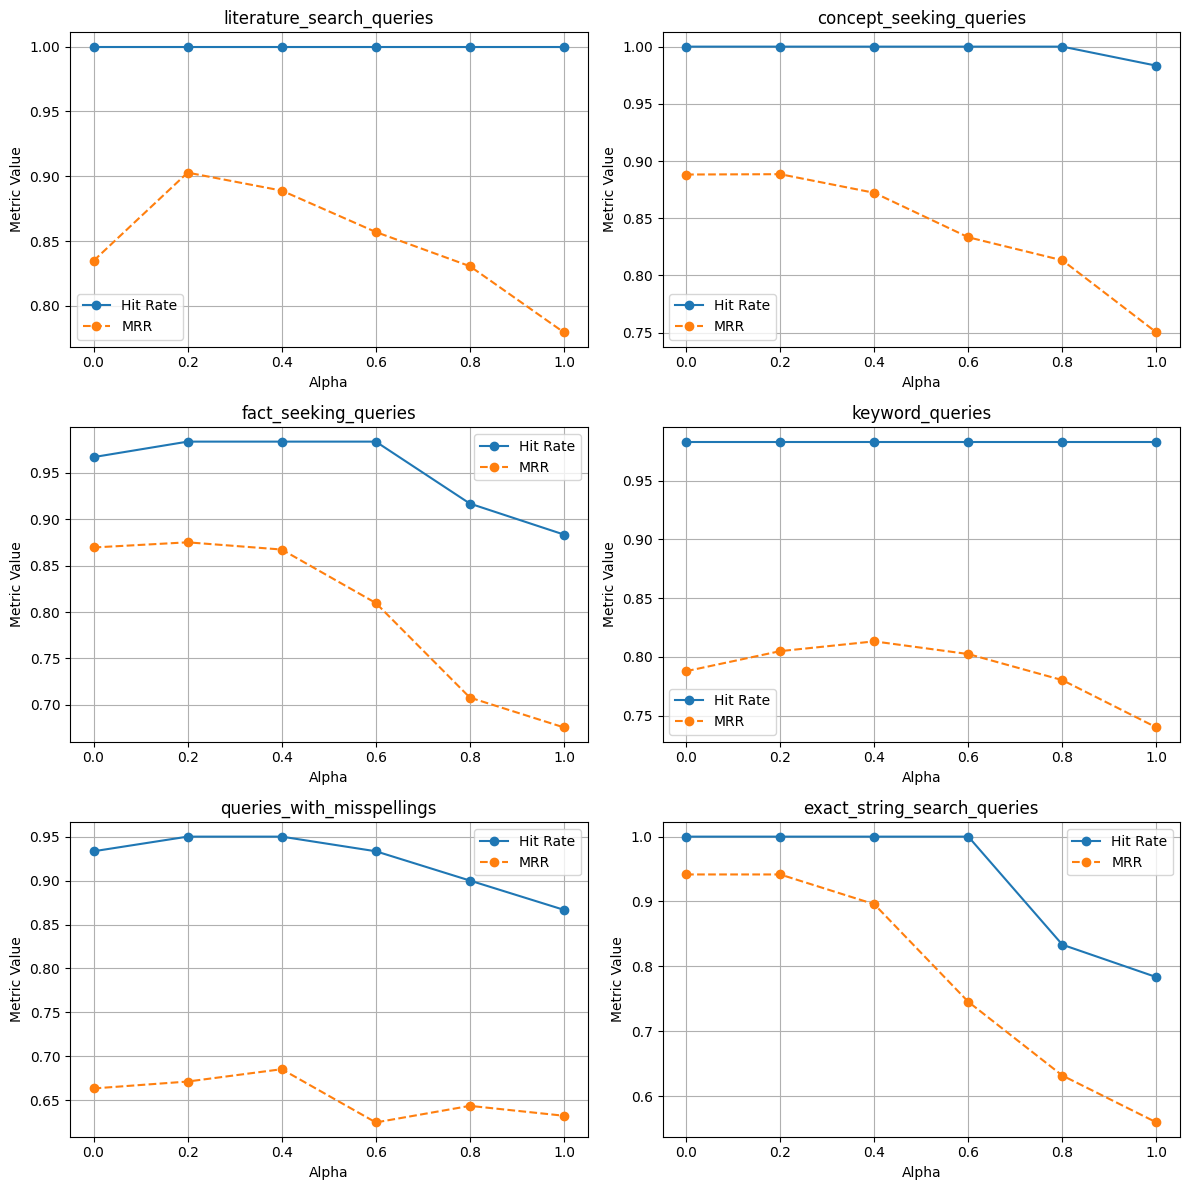

In [34]:
import nest_asyncio

nest_asyncio.apply()

asyncio.run(main())

In [35]:
qid, query = next(iter(keyword_queries_multi_document.queries.items()))
print(query)
gold_ids = keyword_queries_multi_document.relevant_docs[qid]  # list of node_ids

hits = hybrid_retriever.retrieve(query)
print("Gold:", gold_ids[:1])
print([h.node.get_content() for h in hits])

"inhalation aromatherapy radiotherapy trial"
Gold: ['366b9499-edd2-4606-b136-92b50dcd5e31']
['Inhalation aromatherapy during radiotherapy: results of a placebo-controlled double-blind randomized trial.', 'To determine whether the inhalation of aromatherapy during radiotherapy reduces anxiety. Three hundred thirteen patients undergoing radiotherapy were randomly assigned to receive either carrier oil with fractionated oils, carrier oil only, or pure essential oils of lavender, bergamot, and cedarwood administered by inhalation concurrently with radiation treatment. Patients underwent assessment by the Hospital Anxiety and Depression Scale (HADS) and the Somatic and Psychological Health Report (SPHERE) at baseline and at treatment completion. ']
